<a href="https://colab.research.google.com/github/van-dang/MRI-Cloud/blob/master/MultilayeredStructuresSim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About the code

In [0]:
# This demo solves the Bloch-Torrey equation applied to computational diffusion MRI using 
# the finite element method coupled with the theta-method for the spatial discretization.

# The scope of usage: 
# (1) multilayered structures, (2) membrane permeability, (3) pure homogeneous Neumann 

# Copyright (C) 2019 Van-Dang Nguyen (vdnguyen@kth.se)

# This file is part of DOLFIN.

# DOLFIN is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# DOLFIN is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU Lesser General Public License for more details.

# You should have received a copy of the GNU Lesser General Public License
# along with DOLFIN. If not, see <http://www.gnu.org/licenses/>.

# First added:  2017-10-10
# Last changed: 2019-04-09

# This demo is maintained by Van-Dang Nguyen
# Please report problems to vdnguyen@kth.se

# Setting a working environment with FEniCS

In [37]:
from google.colab import files

import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion

if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
    print("Python3 is needed!");
    print("How to fix: Runtime/Change_runtime_type/Python 3");
    sys.exit()
    
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *

gmsh_dir=!which gmsh
if len(gmsh_dir)==0:
  !apt-get install gmsh
    
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot 
import time

import os, sys, shutil

clear_output()

dolfin_version = dolfin.__version__
print ('dolfin version:', dolfin_version)

!rm -rf * # clean up all files
# Useful commands
# Remove an empty folder      : os.rmdir("my_results")
# Remove a folder with files  : shutil.rmtree("results")
# Make a folder               : os.mkdir("my_results")
# Runtime/Change_runtime_type/Python3

# Disable dolfin warnings
import logging
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger("rothemain.rothe_utils")
logging.getLogger('UFL').setLevel(logging.WARNING)
logging.getLogger('FFC').setLevel(logging.WARNING)

import warnings
warnings.filterwarnings("ignore")


dolfin version: 2018.1.0


#Load pre-defined functions

In [38]:
exists = os.path.isfile('DmriFemBuitInFunc.py')
isupdate = True
if (exists==False or isupdate==True):
    if isupdate==True:
        !rm DmriFemBuitInFunc.py
    print("Load pre-defined functions from GitHub")
    !wget --quiet https://raw.githubusercontent.com/van-dang/MRI-Cloud/master/DmriFemBuitInFunc.py

from DmriFemBuitInFunc import *

class MRI_parameters():
    def __init__(self):
        # Initialize default parameters
        self.bvalue = None
        self.qvalue = None        
        self.gdir = [1, 0, 0];
        self.stype='PGSE'
        self.nperiod = 0; # number of period for OGSE sequences
    def set_gradient_dir(self, mymesh, g0, g1, g2):
        gdim = mymesh.geometry().dim()
        if gdim==2:
            self.gdir = Point(g0, g1)
            self.gdir /= self.gdir.norm()
            self.g = Expression(("g0","g1"), g0=self.gdir.x(), g1=self.gdir.y(),domain=mymesh, degree=1);
        if gdim==3:
            self.gdir = Point(g0, g1, g2)
            self.gdir /= self.gdir.norm()        
            self.g = Expression(("g0","g1","g2"), g0=self.gdir.x(), g1=self.gdir.y(), g2=self.gdir.z(),domain=mymesh, degree=1);
    def time_profile(self, t):
        ft1, ft2 = 0, 0;
        if self.stype=='PGSE':
            ft1 = 1.0*(t>=0 and t<self.delta) 
            ft2 = -1.0*(t>=self.Delta and t<=self.Delta+self.delta);
        if self.stype=='cos_OGSE':
            ft1 =  cos(2.0*self.nperiod*pi*t/self.delta)*(t>=0 and t<self.delta);
            ft2 = -cos(2.0*self.nperiod*pi*(t-2.*self.delta)/self.delta)*(t>=Delta and t<=self.Delta+self.delta);
        return ft1 + ft2; 
    def itime_profile(self, t): 
        # integrate ft
        ft1, ft2, ft3 = 0, 0, 0;
        if self.stype=='PGSE':
            ft1 = t*(t>=0 and t<self.delta) 
            ft2 = self.delta*(t>=self.delta and t<self.Delta) 
            ft3 = (self.delta - t + self.Delta)*(t>=self.Delta and t<=self.Delta+self.delta) 
        if self.stype=='cos_OGSE':
 	          ft1 = 1.0/2.0*self.delta*sin(2.0*t*self.nperiod*pi/self.delta)/self.nperiod/pi * (t >= 0 and  t <= self.delta)
 	          ft2 = 1.0/2.0*self.delta*(sin(2.0*self.Delta*self.nperiod*pi/self.delta)-sin(2.0*t*self.nperiod*pi/self.delta))/nperiod/pi *(t>=self.Delta and t<=self.Delta+self.delta)
        return ft1 + ft2 + ft3;  
    def convert_b2g(self):
        self.gnorm = 0;
        if (self.stype == 'PGSE'):
            self.gnorm = sqrt(self.bvalue)/sqrt(self.delta*self.delta*(self.Delta-self.delta/3.0));
        if (self.stype == 'cos_OGSE'):
            self.gnorm = sqrt(self.bvalue/(1./8.*self.delta*self.delta*self.delta*(3.-cos(4.*self.nperiod*pi/self.delta*self.Delta))/(self.nperiod*self.nperiod)/(pi*pi)));
        if (self.stype == 'sin_OGSE'):
            self.gnorm = sqrt(self.bvalue/(1./8.*self.delta*self.delta*self.delta*(5.+cos(4.*self.nperiod*pi/self.delta*self.Delta))/(self.nperiod*self.nperiod)/(pi*pi)));
        return self.gnorm
    def convert_g2b(self):
        self.bvalue = 0;
        if (self.stype == 'PGSE'):
            self.bvalue = self.gnorm*self.gnorm*self.delta*self.delta*(self.Delta-self.delta/3.0);
        if (self.stype == 'cos_OGSE'):
            self.bvalue=self.gnorm*self.gnorm*1./8.*self.delta*self.delta*self.delta*(3.-cos(4.*self.nperiod*pi/self.delta*self.Delta))/(self.nperiod*self.nperiod)/(pi*pi);
        if (self.stype == 'sin_OGSE'):
	          self.bvalue=self.gnorm*self.gnorm*1./8.*self.delta*self.delta*self.delta*(5.+cos(4.*self.nperiod*pi/self.delta*self.Delta))/(self.nperiod*self.nperiod)/(pi*pi);
        return self.bvalue
      
    def Apply(self):
        self.T = self.Delta+self.delta;
        if not(self.bvalue==None):
            self.gnorm = self.convert_b2g();
            self.qvalue = convert_g2q(self.gnorm);
        elif not(self.qvalue==None):
            self.gnorm = convert_q2g(self.qvalue);
            self.bvalue = self.convert_g2b();
        elif (self.bvalue==None and self.bvalue==None):
            print("bvalue or qvalue need to be specified.")
            sys.exit()      
          
class MRI_simulation():
    def __init__(self):
          self.nskip = 5;    # Output frequency (for visualization only)
          self.theta = 0.5;  # theta=0.5: midpoint method

    def InitialCondition(self, mydomain):
          if mydomain.gdim==2:
              Dirac_Delta = Expression("x[0]*x[0]+x[1]*x[1]<eps",eps=1e6, domain=mydomain.mymesh, degree=1);
          if mydomain.gdim==3:
              Dirac_Delta = Expression("x[0]*x[0]+x[1]*x[1]+x[2]*x[2]<eps",eps=1e6, domain=mydomain.mymesh, degree=1);
          Dirac_Delta = interpolate(Dirac_Delta, mydomain.V);
          u_0 = Function(mydomain.W);
          assign(u_0.sub(0), Dirac_Delta)
          if (mydomain.IsDomainMultiple==True):
              assign(u_0.sub(2), Dirac_Delta)  
          return Dirac_Delta, u_0
        
    def solve(self, mydomain, mri_para, linsolver=PETScLUSolver("mumps")): 
      
          self.Dirac_Delta, self.u_0 = self.InitialCondition(mydomain)
          
          stepcounter = 0;

          M = MassMatrix(mydomain);

          self.t = 0;
          ft_prev  =  mri_para.time_profile(self.t);
          ift_prev = mri_para.itime_profile(self.t);

          start_time = time.time()
          
          while self.t < mri_para.T + self.k: # Time-stepping loop
              if stepcounter % self.nskip == 0:
                  print('t: %f '%self.t, 'T: %.1f'%mri_para.T, 'dt: %.1f'%self.k,'gnorm: %e'%mri_para.gnorm,'Completed %.2f%%'%(float(self.t)/float(mri_para.T+mri_simu.k)*100.0));

              ft = mri_para.time_profile(self.t);
              ift = mri_para.itime_profile(self.t);
              L = ThetaMethodL(ft_prev, ift_prev, mri_para, self, mydomain);
              A = 1/self.k*M + assemble(ThetaMethodF(ft, ift, mri_para, self, mydomain))

              b = assemble(L);

              linsolver.solve(A, self.u_0.vector(),b);

              ft_prev  = ft;
              ift_prev = ift;

              self.t += self.k;
              stepcounter += 1;

          elapsed_time = time.time() - start_time
          print("Successfully Completed! Elapsed time: %f seconds"%elapsed_time)

rm: cannot remove 'DmriFemBuitInFunc.py': No such file or directory
Load pre-defined functions from GitHub


# Working on the mesh and submesh

Converting from Gmsh format (.msh, .gmsh) to DOLFIN XML format
Expecting 887 vertices
Found all vertices
Expecting 3904 cells
Found all cells
Conversion done
Converting from Gmsh format (.msh, .gmsh) to DOLFIN XML format
Expecting 229 vertices
Found all vertices
Expecting 952 cells
Found all cells
Conversion done


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:not adjusting title pos because title was already placed manually: 0.920000
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


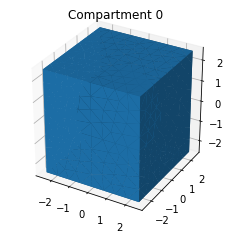

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:not adjusting title pos because title was already placed manually: 0.920000
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


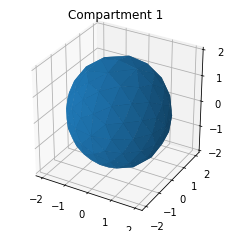

In [39]:
if 1==2:
  # mesh_name = "multi_layered_disk"

  # mesh_name = "CircleInSquare"

  mesh_name = "SphereInBox"

  # mesh_name = "multi_layered_cylinder"

  # !rm -rf *
  !wget --quiet https://raw.githubusercontent.com/van-dang/MRI-Cloud/mesh/GetPartitionMarkers.py
  !wget --quiet https://raw.githubusercontent.com/van-dang/MRI-Cloud/mesh/$mesh_name''.geo

  !sed -i 's/5, 7.5, 10, 13/5, 7.5, 10/g' $mesh_name''.geo
  # !sed -i 's/lc = 1/lc = 0.5/g' $mesh_name''.geo

  !gmsh -3 $mesh_name''.geo -o $mesh_name''.msh
  !dolfin-convert $mesh_name''.msh $mesh_name''.xml

  mymesh = Mesh(mesh_name+".xml");  
 
  clear_output()
  
  from GetPartitionMarkers import *

  partion_list=GetPartitionMarkers(mesh_name+".msh", "pmk_"+mesh_name+".xml")

  partition_marker = MeshFunction("size_t", mymesh, mymesh.topology().dim())

  File("pmk_"+mesh_name+".xml")>>partition_marker

  cmpt_mesh = SubMesh(mymesh, partition_marker, 0)


'''
!rm -rf *
!wget --quiet https://raw.githubusercontent.com/van-dang/MRI-Cloud/master/comri/meshes/multi_layer_torus.xml.zip
!wget --quiet https://raw.githubusercontent.com/van-dang/MRI-Cloud/master/comri/meshes/multi_layer_torus_compt1.xml.zip
!unzip -q multi_layer_torus.xml.zip
!unzip -q multi_layer_torus_compt1.xml.zip
!rm -rf *.zip *MACOSX

# Load multilayered torus mesh and submesh
mesh = Mesh("multi_layer_torus.xml");  
cmpt_mesh = Mesh('multi_layer_torus_compt1.xml')

'''

if 1==1:
  !rm -rf *
  mesh_name = "SphereInBox"
  !wget --quiet https://raw.githubusercontent.com/van-dang/MRI-Cloud/mesh/$mesh_name''.msh.zip
  !wget --quiet https://raw.githubusercontent.com/van-dang/MRI-Cloud/mesh/$mesh_name''_cmpt.msh.zip
  
  !unzip -q $mesh_name''.msh.zip
  !unzip -q $mesh_name''_cmpt.msh.zip

  !dolfin-convert $mesh_name''.msh $mesh_name''.xml
  !dolfin-convert $mesh_name''_cmpt.msh $mesh_name''_cmpt.xml
  mymesh = Mesh(mesh_name+".xml");  
  cmpt_mesh = Mesh(mesh_name+"_cmpt.xml");

V_DG = FunctionSpace(mymesh, 'DG', 0)
dofmap_DG = V_DG.dofmap()
phase = Function(V_DG)
cellmarker = MeshFunction("size_t", mymesh, mymesh.topology().dim())

for cell in cells(mymesh):
    p = cell.midpoint();
    is_in_cmpt = cmpt_mesh.bounding_box_tree().compute_first_entity_collision(p)<4294967295
    phase.vector()[dofmap_DG.cell_dofs(cell.index())] = is_in_cmpt;
    cellmarker[cell.index()] = is_in_cmpt;
    
# plot(phase, cmap="coolwarm");
mesh0 = SubMesh(mymesh, cellmarker, 0)
mesh1 = SubMesh(mymesh, cellmarker, 1)
File("Phase.pvd")<<phase
File("mesh0.xml")<<mesh0
File("mesh1.xml")<<mesh1
plt.figure(2); plot(mesh0, title="Compartment 0"); 
plt.figure(3); plot(mesh1, title="Compartment 1")  



# Solve the Bloch-Torrey equation

In [40]:
mri_simu = MRI_simulation()
mri_para = MRI_parameters()

#################################################################################
#########################  Pre-defined parameters ###############################
mri_para.stype='PGSE'                                 # Sequence type
mri_para.bvalue = 1000;                               # bvalue
mri_para.delta, mri_para.Delta = 10000, 10000         # Time sequence
mri_para.set_gradient_dir(mymesh, 1, 0, 0)              # gradient direction
mri_para.Apply()

mydomain = MyDomain(mymesh, mri_para)
mydomain.phase = phase
mydomain.PeriodicDir = [1, 0, 0];          # Direction of the periodicity
mydomain.IsDomainPeriodic = True          # Confirm if the mesh if periodic
mydomain.IsDomainMultiple = False           # Confirm if the mesh is multiple
mydomain.kappa = 1e-1                        # Permeability
mri_simu.k = 400; # Time-step size
################################################################################

mydomain.Apply()   # Call Apply before setting the diffusion tensor

################################################################################
# Impose the diffusion coefficient
D0 = 3e-3

# Impose diffusion coefficient
# mydomain.D = D0;

############### Impose the diffusion tensor
# Constant tensor
# d00, d01, d02, d10, d11, d12, d20, d21, d22 = D0, 0, 0, 0, D0, 0, 0, 0, D0

# Variable tensor
dofmap_DG = mydomain.V_DG.dofmap()
d00 = Function(mydomain.V_DG); d01 = Function(mydomain.V_DG); d02 = Function(mydomain.V_DG)
d10 = Function(mydomain.V_DG); d11 = Function(mydomain.V_DG); d12 = Function(mydomain.V_DG)
d20 = Function(mydomain.V_DG); d21 = Function(mydomain.V_DG); d22 = Function(mydomain.V_DG)

for cell in cells(mymesh):
    p = cell.midpoint() # the coordinate of the cell center.
    d00.vector()[dofmap_DG.cell_dofs(cell.index())] = D0
    d11.vector()[dofmap_DG.cell_dofs(cell.index())] = D0
    d22.vector()[dofmap_DG.cell_dofs(cell.index())] = D0

mydomain.ImposeDiffusionTensor(d00, d01, d02, d10, d11, d12, d20, d21, d22)
#################################################################################
#################################################################################
    
mri_simu.solve(mydomain, mri_para)

Function Space for Single Domains has 2 components
(ur, ui): r-real, i-imaginary
Initialize peridodic function spaces.
The pseudo-periodic BCS are strongly imposed.
The mesh needs to be periodic.
Impose Diffusion Tensor
[
  [f_3646, f_3649, f_3652],
  [f_3655, f_3658, f_3661],
  [f_3664, f_3667, f_3670]
]
t: 0.000000  T: 20000.0 dt: 400.0 gnorm: 3.872983e-05 Completed 0.00%
t: 2000.000000  T: 20000.0 dt: 400.0 gnorm: 3.872983e-05 Completed 9.80%
t: 4000.000000  T: 20000.0 dt: 400.0 gnorm: 3.872983e-05 Completed 19.61%
t: 6000.000000  T: 20000.0 dt: 400.0 gnorm: 3.872983e-05 Completed 29.41%
t: 8000.000000  T: 20000.0 dt: 400.0 gnorm: 3.872983e-05 Completed 39.22%
t: 10000.000000  T: 20000.0 dt: 400.0 gnorm: 3.872983e-05 Completed 49.02%
t: 12000.000000  T: 20000.0 dt: 400.0 gnorm: 3.872983e-05 Completed 58.82%
t: 14000.000000  T: 20000.0 dt: 400.0 gnorm: 3.872983e-05 Completed 68.63%
t: 16000.000000  T: 20000.0 dt: 400.0 gnorm: 3.872983e-05 Completed 78.43%
t: 18000.000000  T: 20000.0 

#Post-processing

b: 1000 Signal: 5.316e-02 , dt:  400 , hmin:  0.4239694427581647 , Free signal: 4.979e-02


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


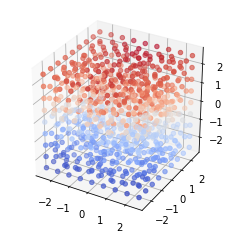

In [41]:
if mydomain.IsDomainMultiple == True:
    u0r_0, u0i_0, u1r_0, u1i_0 = split(mri_simu.u_0)
    signal0 = assemble(((1-mydomain.phase)*u0r_0)*dx)/assemble((1-mydomain.phase)*mri_simu.Dirac_Delta*dx);
    signal1 = assemble((mydomain.phase*u1r_0)*dx)/assemble(mydomain.phase*mri_simu.Dirac_Delta*dx);
    signal = assemble((mydomain.phase*u1r_0+(1-mydomain.phase)*u0r_0)*dx)/assemble(mri_simu.Dirac_Delta*dx);
    print('Signal on each compartment')
    print('Signal0: %.3e'%signal0)
    print('Signal1: %.3e'%signal1)
    print('b:',mri_para.bvalue, 'Signal: %.3e'%signal,'kappa: %.3e'%mydomain.kappa,', dt: ',mri_simu.k,', hmin: ',mydomain.hmin, ', Free signal: %.3e'%(exp(-mri_para.bvalue*D0)))
    V0 = FunctionSpace(mesh0, mydomain.Ve);
    V1 = FunctionSpace(mesh1, mydomain.Ve);
    u0r_0p = project(u0r_0,V0)
    u1r_0p = project(u1r_0,V1)
    plot(u0r_0p, cmap="coolwarm")
    plot(u1r_0p, cmap="coolwarm")  
else:
    ur, ui = split(mri_simu.u_0)
    signal = assemble(ur*dx)/assemble(mri_simu.Dirac_Delta*dx);
    print('b:',mri_para.bvalue, 'Signal: %.3e'%signal,', dt: ',mri_simu.k,', hmin: ',mydomain.hmin, ', Free signal: %.3e'%(exp(-mri_para.bvalue*D0)))
    V = FunctionSpace(mymesh,mydomain.Ve);
    ur_p = project(ur,V)
    plot(ur_p, cmap="coolwarm")



# Reference solutions

In [0]:
# The results were generated by the Matrix Formalism method propsed in
# D.S. Grebenkov, Pulsed-gradient spin-echo monitoring of restricted 
# diffusion in multilayered structures, J. Magn. Reson., 205 (2) (2010)
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# # # R=[5,7.5,10], kappa=5e-5m/s delta=Delta=40000
#  bvalue  # signal attenuation
# # # # # # # # # # # # # # #
# # # # # # # # # # # # # # #